In [162]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1. 加载图像
img1 = cv2.imread('../source/template2.jpg')  # 查询图像
img2 = cv2.imread('../source/1.2/tv201712281045269FF0WY.jpg')  # 训练图像

# 2. 创建AKAZE特征检测器
akaze = cv2.AKAZE_create()

# 3. 检测特征点和描述符
kp1, des1 = akaze.detectAndCompute(img1, None)
kp2, des2 = akaze.detectAndCompute(img2, None)

# 4. 使用暴力匹配（Brute Force Matcher）
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# 5. 对匹配进行排序
matches = sorted(matches, key=lambda x: x.distance)

# 6. 获取匹配的关键点坐标
pts1 = np.array([kp1[m.queryIdx].pt for m in matches], dtype=np.float32)
pts2 = np.array([kp2[m.trainIdx].pt for m in matches], dtype=np.float32)


In [163]:
def show_img(image):
    # OpenCV 读取的图像是 BGR 格式，而 Matplotlib 显示的是 RGB 格式
    # 因此需要将图像从 BGR 转换为 RGB
    if image is None: print("Error: Unable to load image.")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 使用 Matplotlib 显示图像
        plt.figure(figsize=(15, 15))
        plt.imshow(image_rgb)
        plt.axis('off')  # 关闭坐标轴
        plt.show()

def show_point(image, x_point, y_point, color = (0, 255, 255), reversed=True):
    image_temp = image.copy()
    for (x, y) in zip(x_point, y_point):
        if reversed: cv2.circle(image_temp, (int(x), int(image.shape[1] - y)), 4, color, -1)
        else: cv2.circle(image_temp, (int(x), int(y)), 4, color, -1)
    show_img(image_temp)

In [164]:

# 7. 使用K-means聚类进行优化匹配点分布
num_clusters = 5  # 聚类数目

# 使用K-means对匹配点坐标进行聚类
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(pts2)

# 获取每个点的聚类标签
labels = kmeans.labels_


In [165]:
labels[:10]

array([4, 3, 4, 4, 4, 4, 4, 3, 3, 0], dtype=int32)

In [166]:
pts_pool1 = [ [] for i in range(num_clusters) ]
pts_pool2 = [ [] for i in range(num_clusters) ]

max_points_per_cluster = 15
for i in range(len(pts2)):
    cluster_label = labels[i]
    if len(pts_pool1[cluster_label]) < max_points_per_cluster:
        pts_pool1[cluster_label].append(pts1[i])
        pts_pool2[cluster_label].append(pts2[i])

In [167]:
# 将分组后的点重新组合为匹配对象
optimized_matches = []
for cluster_idx in range(num_clusters):
    for i in range(len(pts_pool1[cluster_idx])):
        # 查找对应的原始匹配对象
        p1 = tuple(pts_pool1[cluster_idx][i])
        p2 = tuple(pts_pool2[cluster_idx][i])
        for match in matches:
            if (
                np.allclose(kp1[match.queryIdx].pt, p1, atol=1e-2)
                and np.allclose(kp2[match.trainIdx].pt, p2, atol=1e-2)
            ):
                optimized_matches.append(match)
                break

In [168]:
len(optimized_matches)

75

In [169]:
# 8. 计算单应矩阵（Homography）
# 注意：传入的点必须是二维数组格式 (N, 2)
pts1_optimized = np.array([kp1[m.queryIdx].pt for m in optimized_matches], dtype=np.float32)
pts2_optimized = np.array([kp2[m.trainIdx].pt for m in optimized_matches], dtype=np.float32)



<Figure size 1500x1000 with 0 Axes>

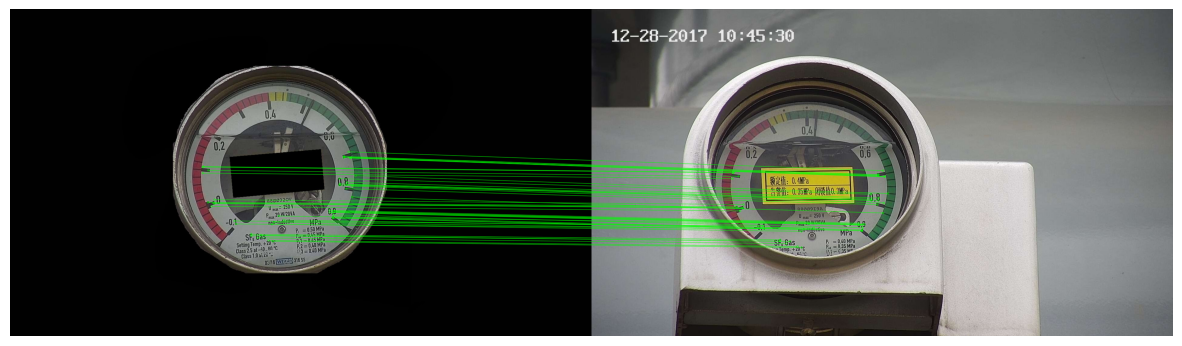

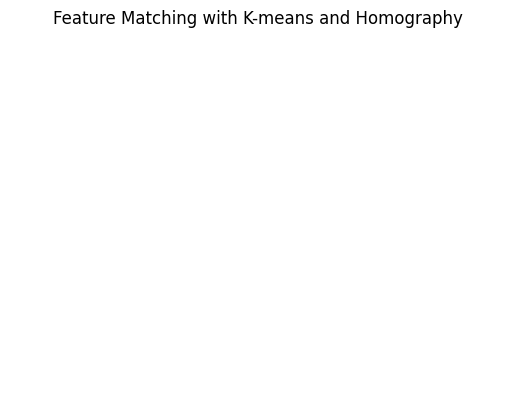

In [170]:
H, mask = cv2.findHomography(pts1_optimized, pts2_optimized, cv2.RANSAC, 5.0)

# 9. 绘制匹配结果并使用掩码
# 创建matches_mask，用于区分内点和外点
matches_mask = mask.ravel().tolist()  # 将mask转化为列表形式，方便传递给drawMatches

# 设置绘制参数（绿色为内点，灰色为外点）
draw_params = dict(matchColor=(0, 255, 0),  # 绿色表示内点
                   singlePointColor=(255, 0, 0),  # 蓝色表示未匹配的点（可选）
                   matchesMask=matches_mask,  # 使用mask过滤掉外点
                   flags=2)

# 绘制匹配结果
img_matches = cv2.drawMatches(
    img1, kp1, img2, kp2, optimized_matches, None, **draw_params)

# 10. 显示匹配结果
plt.figure(figsize=(15, 10))
show_img(img_matches)
plt.title('Feature Matching with K-means and Homography')
plt.axis('off')
plt.show()

In [171]:
candidate_point = np.array([
    (700,766),
    (624,659), (603,528), (647,403), (745,311), (851,276),
    (981,292), (1086,361), (1152,472), (1160,601),
    (1107,720)
], dtype=float)

p1= candidate_point.T[0]
p2 = img1.shape[1] - candidate_point.T[1]

candidate_projected_points = cv2.perspectiveTransform(candidate_point.reshape(-1,1,2), H).reshape(-1,2)

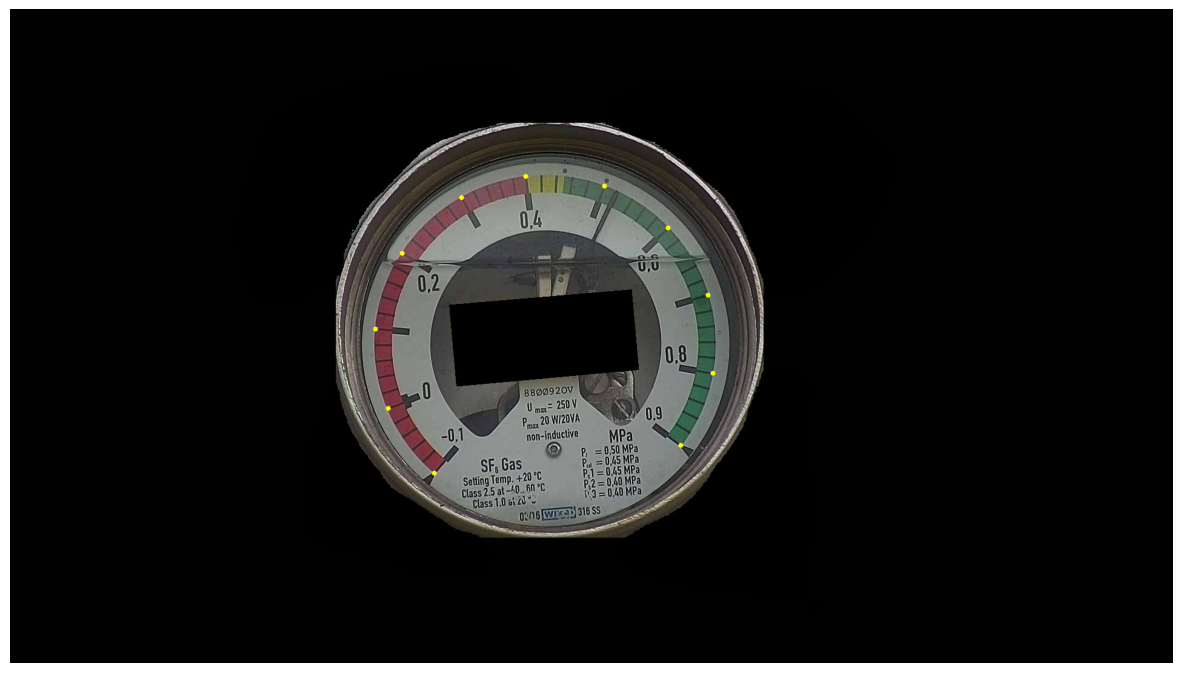

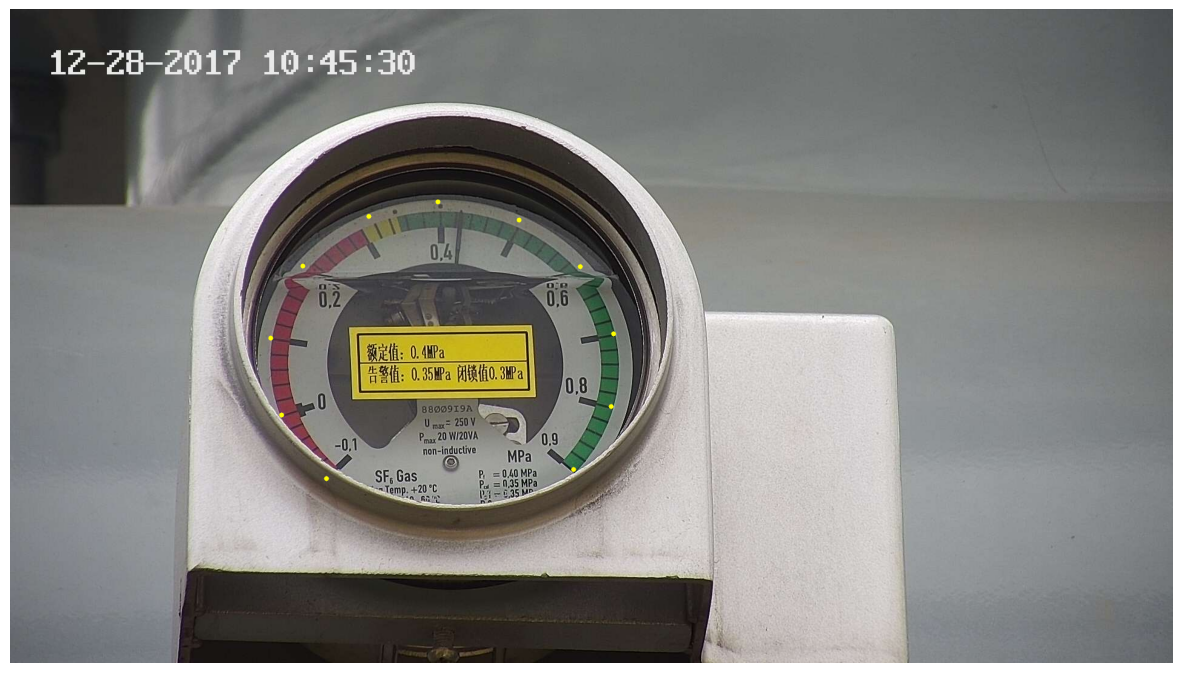

In [172]:
show_point(img1, p1, p2)
show_point(img2, candidate_projected_points.T[0], candidate_projected_points.T[1], reversed=False)